In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def market_update( S_m , p ,delta ):
    U = np.random.rand()
    if U < p :
        S_m_new = S_m * np.exp(delta)
    else:
        S_m_new = S_m * np.exp(-delta)
    
    return S_m_new

def pool_update( S_p , S_m_new , gamma ):
    if S_m_new > gamma**-1*S_p :
      
        S_p_new =  gamma*S_m_new 
    
    elif S_m_new < gamma*S_p :
        S_p_new =  gamma**-1*S_m_new
    
    else:
        S_p_new = S_p
   
    return S_p_new

In [3]:
def pool_process( T , p , delta , gamma ):
    S_p_array = np.zeros(T+1)
    S_m_array = np.zeros(T+1)
    S_p_array[0]=1
    S_m_array[0]=1
    for i in range(T):
        S_m_array[i+1] = market_update( S_m_array[i] , p ,delta )
        S_p_array[i+1] = pool_update( S_p_array[i] , S_m_array[i+1] , gamma )
    return S_p_array , S_m_array

In [4]:
delta = 1
k=1
gamma = np.exp(-k*delta)

# Total run time should be as large as possible
T= 1000

S_p_array , S_m_array = pool_process( T , 0.6 , delta , gamma )


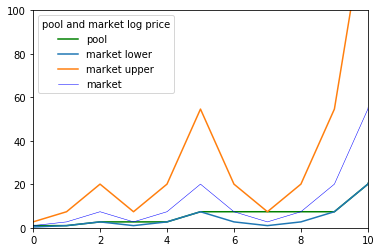

In [12]:
plt.figure()
S_p_array , S_m_array = pool_process( T , 0.6 , delta , gamma )
T_array=np.arange(T+1)
plt.plot(T_array, S_p_array ,'g' , label='pool')
plt.plot(T_array, gamma*S_m_array , label='market lower')
plt.plot(T_array, S_m_array*(gamma**-1) , label='market upper' )
plt.plot(T_array, S_m_array , 'b',linewidth=0.5 , label='market')
plt.legend(title="pool and market log price")

plt.xlim(0,10)
plt.ylim(0,100)
plt.show()

In [56]:
def position(P_a,P_b,L,S_p):
    X =L * (np.sqrt(S_p) - np.sqrt(P_a) )
    Y = L * (1/np.sqrt(S_p) - 1/np.sqrt(P_b))
    if S_p > P_b :
        X = L * (np.sqrt(P_b) - np.sqrt(P_a) )
        Y = 0
    elif S_p < P_a :
        X = 0
        Y = L * (1/np.sqrt(P_a) - 1/np.sqrt(P_b))
    return X,Y
position(10,100,5,2)

(0, 1.0811388300841898)

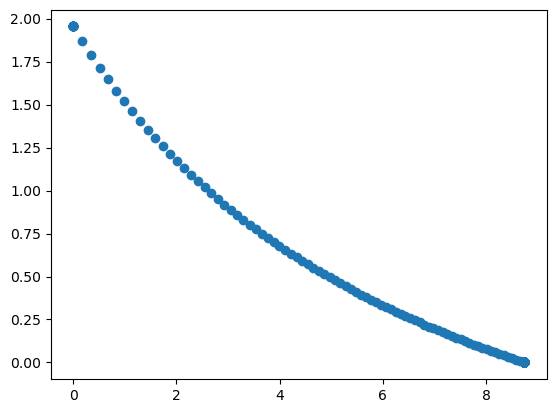

In [57]:
# An example of position curve 
X =np.array( [position(2,10,5,s/10 )[0] for s in range(1,1000)] )
Y = np.array( [position(2,10,5,s/10 )[1] for s in range(1,1000)] )
plt.scatter( X , Y )

In [66]:
def position_value(P_a,P_b,L,S_p , S_m):
    return position(P_a,P_b,L,S_p)[0]+ S_m*position(P_a,P_b,L,S_p)[1]

In [59]:
position_value(P_a,P_b,L, 5 , 5)

0.8218544151266947

In [14]:
#without scaling assumption
def fee_collecting( P_a,P_b , gamma ,  L , S_p_old , S_p_new , S_m_new ):
    A = max(S_p_old , P_a)
    B = min(S_p_old , P_b)
    fee = 0
    if S_p_old < P_b :
        if S_p_new > A :
            
            fee = L*(1-gamma)/gamma *( np.sqrt( min( S_p_new , P_b) ) - np.sqrt( A ))
            print("forward fee" , fee)
            
    if S_p_old > P_a :
        if S_p_new < B :
            fee = L*(1-gamma)/gamma *S_m_new*( 1/np.sqrt( max( S_p_new , P_a) ) - 1/np.sqrt( B ))
            print("backward fee" , fee)
    return fee

In [29]:
fee_collecting( P_a = 2.3 , P_b = 5 , gamma = gamma ,  L = 1 , S_p_old = 2.2 , S_p_new = 5 , S_m_new = 5 )

forward fee 1.2362915563406396


1.2362915563406396

In [52]:
def disc_fee_process(r,P_a,P_b , gamma ,  L , S_p_array , S_m_array) :
    # time 0 ~ T
    T = len(S_p_array) - 1
    F = np.zeros(T+1)
    t= 1
    # run from 1 ~ T
    while t >0 and t <= T:
        fee = fee_collecting( P_a , P_b , gamma ,  L , S_p_array[t-1] , S_p_array[t] , S_m_array[t] )
        F[t] = F[t-1] + np.exp(-r*t)*fee
        if fee != 0 :
            print(t)
        t = t+1
    return F     

In [19]:
fee_process(1,5 , gamma ,  1 , S_p , S_m)

forward fee 1.1146859711788915
2
forward fee 1.0092271732991211
3


array([0.        , 0.        , 1.11468597, ..., 2.12391314, 2.12391314,
       2.12391314])

In [67]:
def stopping_time_boundary(P_l , P_u , S_p_array):
    t = 0
    while True :
        if S_p_array[t] == P_l or S_p_array[t] == P_u :
            return t
        t = t+1
        
#stopped at a given timing
def disc_wealth_stopped(r ,P_a,P_b , gamma ,  Tau ,  L , S_p_array , S_m_array):
    S_p = S_p_array[Tau]
    S_m = S_m_array[Tau]
    
    fee_part = disc_fee_process(r,P_a,P_b , gamma , L , S_p_array[:Tau+1] , S_m_array[:Tau+1])[-1]
    asset_part = np.exp(-r*Tau)*position_value(P_a,P_b,L, S_p , S_m)
    
    return  fee_part + asset_part 

### Expected wealth (stop at boundary)

In [99]:
gamma = 0.997
delta = -np.log(gamma)/5
P_a = np.exp(-2*delta)
P_b = np.exp(5*delta)
T = 10000
p =0.6
P_l = 1
P_u = 6
L = 1
r = 0.01
def expected_wealth_boundary(T,p , delta , gamma , r ,P_a,P_b , P_l , P_u ,  L ):
    data = np.zeros(1000)
    for i in range(1000):
        print(i)
        S_p_array , S_m_array = pool_process( T , p , delta , gamma )
        Tau = stopping_time_boundary(P_l , P_u , S_p_array)
        data[i]=disc_wealth_stopped(r ,P_a,P_b , gamma ,  Tau ,  L , S_p_array , S_m_array)
        i = i+1
    return np.average(data)

In [100]:
W1 =expected_wealth_boundary(T,p , delta , gamma , r ,P_a,P_b , P_a , P_b ,  L )
W2 =expected_wealth_boundary(T,p , delta , gamma , r ,P_a,P_b , P_a*np.exp(-delta) , P_b*np.exp(delta) ,  L )
W3 =expected_wealth_boundary(T,p , delta , gamma , r ,P_a,P_b , P_a*np.exp(-2*delta) , P_b*np.exp(2*delta) ,  L )

0


IndexError: index 10001 is out of bounds for axis 0 with size 10001

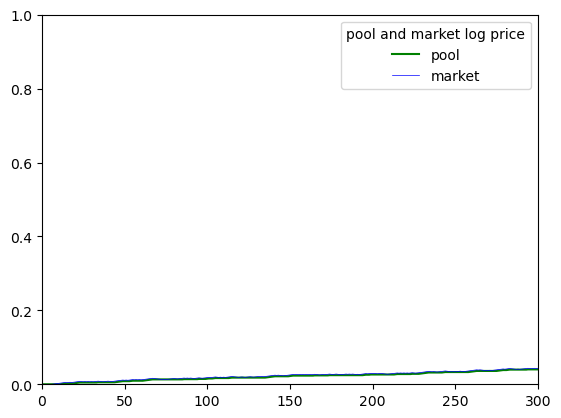

In [102]:
plt.figure()
S_p_array , S_m_array = pool_process( T , 0.6 , delta , gamma )
T_array=np.arange(T+1)
plt.plot(T_array, np.log(S_p_array) ,'g' , label='pool')
#plt.plot(T_array, np.log(gamma*S_p_array) , label='pool lower')
#plt.plot(T_array, np.log(S_p_array*(gamma**-1)) , label='pool upper' )
plt.plot(T_array, np.log(S_m_array) , 'b',linewidth=0.5 , label='market')
plt.legend(title="pool and market log price")

plt.xlim(0,300)
plt.ylim(0,1)
plt.show()